In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import gpytorch
import torch

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import george
from george import kernels

from lsst.meas.algorithms import CloughTocher2DInterpolatorUtils as ctUtils

In [49]:
def timer(f):
    import functools

    @functools.wraps(f)
    def f2(*args, **kwargs):
        import time
        import inspect

        t0 = time.time()
        result = f(*args, **kwargs)
        t1 = time.time()
        fname = repr(f).split()[1]
        print("time for %s = %.4f" % (fname, t1 - t0))
        return result

    return f2


class GPRegressionModelKISS(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModelKISS, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. 
        # This util can help with that. Here we are using a grid that has 
        # the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to 
        # adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x, 1.0)
        print(grid_size)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class gp_torch():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
    
        self.hypers = {
            # 'likelihood.noise_covar.noise': torch.tensor(white_noise),
            'covar_module.base_kernel.lengthscale': torch.tensor(correlation_length),
            'covar_module.outputscale': torch.tensor(std),
        }
        # print('ok')
    @timer
    def fit(self, x, y):

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()# noise_constraint=gpytorch.constraints.GreaterThan(1e-15))
        self.model = GPRegressionModelKISS(x, y, self.likelihood)
        # self.model.initialize(**self.hypers)
        self.model.eval()
        self.likelihood.eval()

    @timer
    def predict(self, x):

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            prediction = self.likelihood(self.model(x))
            y_predict = prediction.mean
        return y_predict

class gp_sklearn():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):

        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    @timer
    def fit(self, x, y):
        alpha = self.white_noise**2
        self.kernel = self.std**2 * RBF(length_scale=self.l)
        self.gp =  GaussianProcessRegressor(kernel=self.kernel, alpha=alpha, optimizer=None)
        self.gp.fit(x, y)

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(x)
        return y_pred

class gp_george():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
        
        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    @timer
    def fit(self, x, y):
        alpha = self.white_noise**2
        kernel = self.std**2 * kernels.ExpSquaredKernel(self.l, ndim=2)
        self.gp = george.GP(kernel, fit_kernel=False, solver=george.HODLRSolver, seed=42)
        self.gp.compute(x, yerr=alpha)
        self._y = y

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(self._y, x, return_var=False, return_cov=False)
        return y_pred


In [50]:
dic = pickle.load(open("data/out_test_0", "rb"))
maskedImage = dic['in']['maskedImage']

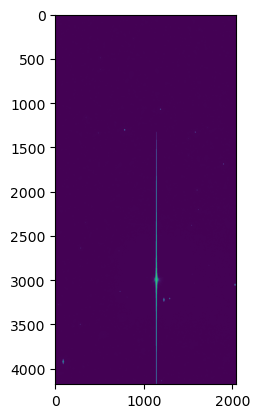

In [51]:
plt.imshow(maskedImage.image.array)

In [52]:
block_size = 20

z = maskedImage.image.array[0:block_size,0:block_size]
y, x = np.indices(np.shape(z))
coordinates = np.array(([x.reshape(-1), y.reshape(-1)])).T

training_data_filter = maskedImage.mask.array[0:block_size,0:block_size] < 1
training_data_filter = training_data_filter.reshape(-1)
z_training = torch.tensor(z.reshape(-1)[training_data_filter])
coordinates_training = torch.tensor(coordinates[training_data_filter])
coordinates_val = torch.tensor(coordinates[~training_data_filter])

In [53]:
gpt = gp_torch(std=2., correlation_length=0.1, white_noise=np.sqrt(1e-10))
gpt.fit(coordinates_training, z_training)
z_validation = gpt.predict(coordinates_val)

7
time for gp_torch.fit = 0.0013
time for gp_torch.predict = 0.0120


In [54]:
gps = gp_sklearn(std=2., correlation_length=0.1, white_noise=np.sqrt(1e-10))
gps.fit(coordinates_training, z_training)
z_validation = gps.predict(coordinates_val)

time for gp_sklearn.fit = 0.0021
time for gp_sklearn.predict = 0.0007


In [55]:
gpg = gp_george(std=2., correlation_length=0.1, white_noise=np.sqrt(1e-10))
gpg.fit(coordinates_training, z_training)
z_validation = gpg.predict(coordinates_val)

time for gp_george.fit = 0.0005
time for gp_george.predict = 0.0009


In [56]:
(2000 / 20) * (4000 / 20) * (0.0005 + 0.0009)

28.0

In [44]:
40 * 80 * 0.05 / 60

2.6666666666666665

In [60]:
import numpy as np

def process_subarrays(arr, n):
    nx, ny = arr.shape
    for x in range(0, nx, n):
        for y in range(0, ny, n):
            sub_nx = min(n, nx - x)
            sub_ny = min(n, ny - y)
            sub_array = arr[x:x+sub_nx, y:y+sub_ny]
            # Process sub_array here
            print(arr)
            print("")
            print(sub_array)  # Example processing step
            print("")
            print("")

# Example usage
nx, ny = 10, 16  # Dimensions of the main array
n = 3  # Size of the sub-array
arr = np.arange(nx*ny).reshape(nx, ny)  # Create a 2D array for demonstration
process_subarrays(arr, n)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15]
 [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
 [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
 [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]]

[[ 0  1  2]
 [16 17 18]
 [32 33 34]]


[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15]
 [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 64  65  66  67  68

In [74]:
bad, good = ctUtils.findGoodPixelsAroundBadPixels(maskedImage, ["BAD", "SAT", "CR", "EDGE"], buffer=15,)

In [75]:
bad.shape

(262709, 3)

In [76]:
good.shape

(442300, 3)

In [77]:
A = maskedImage.getImage()
A.array.reshape(-1).shape

(8552448,)

In [79]:
442300 / 8552448

0.05171618699113985

In [80]:
class GaussianProcessHODLRSolver():

    def __init__(self, variance=1., correlation_length=1., white_noise=0., mean=0.):
        
        self.variance = variance
        self.correlation_lenght = correlation_length
        self.white_noise  = white_noise
        self.mean = mean

    @timer
    def fit(self, x, y):
        kernel = self.variance * kernels.ExpSquaredKernel(self.correlation_length, ndim=2)
        self.gp = george.GP(kernel, mean=self.mean,
                            fit_kernel=False,
                            solver=george.HODLRSolver, seed=42)
        self.gp.compute(x, yerr=self.white_noise)
        self._y = y

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(self._y, x, return_var=False, return_cov=False)
        return y_pred


class InterpolateOverDefectGaussianProcess():

    @timer
    def __init__(self, maskedImage, defects=["BAD", "SAT", "CR", "EDGE"], fwhm=5, block_size=100):

        self.maskedImage = maskedImage
        self.defects = defects

        # Define hyperparameters for GPs.
        # Kernel would be isotropic RBF (simple / agnostic choice)
        # Amplitude of the kernel would be variance observed on the image.
        # Correlation lenght would be PSF size.
        # White noise would be standard deviation of the variance map.
        # Mean would be set to the mean in the whole CCD.
        # In order to do processing fast, sub-divide GP computation on a block.
        # Block shape is block_size * block_size

        self.correlation_lenght = fwhm
        self.white_noise = np.sqrt(np.mean(maskedImage.getVariance().array))
        self.kernel_amplitude = np.var(maskedImage.getImage().array) - self.white_noise**2
        self.mean = np.mean(maskedImage.getImage().array)

        self.block_size = block_size

    @timer
    def interpolate_over_defects(self):

        nx = self.maskedImage.getDimensions()[0]
        ny = self.maskedImage.getDimensions()[1]
        for x in range(0, nx, n):
            for y in range(0, ny, n):
                sub_nx = min(n, nx - x)
                sub_ny = min(n, ny - y)
                sub_masked_image = self.maskedImage[x:x+sub_nx, y:y+sub_ny]
                sub_masked_image = self.interpolate_sub_masked_image(sub_masked_image)
                self.maskedImage[x:x+sub_nx, y:y+sub_ny] = sub_masked_image


    @timer
    def interpolate_sub_masked_image(self, sub_masked_image):

        cut = self.correlation_lenght * 3
        bad_pixel, good_pixel = ctUtils.findGoodPixelsAroundBadPixels(sub_masked_image, self.defects, buffer=cut)

        # gp interpolation
        gp_hodlr = GaussianProcessHODLRSolver(variance=self.kernel_amplitude, correlation_length=self.correlation_lenght,
                                              white_noise=self.white_noise, mean=self.mean)
        gp.fit(good_pixel[:,:2], good_pixel[:,2:])
        bad_pixel[:,2:] = gp.predict(bad_pixel[:,:2])

        # update_value
        ctUtils.updateImageFromArray(sub_masked_image.image, bad_pixel)

        return sub_masked_image

        


                
        

        


In [82]:
maskedImage.getVariance().array

array([[  39.178364,   62.77914 ,   85.46108 , ...,   82.15378 ,
          63.058716,   37.5518  ],
       [  42.757584,   66.50141 ,   86.16903 , ...,   84.81048 ,
          65.40809 ,   42.3724  ],
       [  45.980587,   69.65063 ,   86.82527 , ...,   87.55836 ,
          68.34259 ,   44.14074 ],
       ...,
       [ 661.9505  ,  376.6934  ,  353.48422 , ...,  791.00854 ,
         777.96826 ,  816.783   ],
       [1338.491   ,  757.10565 ,  690.22394 , ..., 1642.8285  ,
        1497.0394  , 1360.4352  ],
       [1764.0193  , 1413.1307  , 1280.6003  , ..., 2447.6067  ,
        2368.0774  , 2222.8623  ]], dtype=float32)

In [101]:
good[:,:2]

array([[  17.,    0.],
       [  18.,    0.],
       [  19.,    0.],
       ...,
       [1995., 4155.],
       [1996., 4155.],
       [1997., 4155.]], dtype=float32)

In [86]:
maskedImage[0:100,0:100] = maskedImage[0:100,0:100] 

In [89]:
maskedImage.getDimensions()[0]

2048

In [104]:
help(ctUtils.updateImageFromArray)

Help on built-in function updateImageFromArray in module lsst.meas.algorithms:

updateImageFromArray(...) method of builtins.PyCapsule instance
    updateImageFromArray(image: lsst.afw.image._image.ImageF, array: numpy.ndarray) -> None

